<a href="https://colab.research.google.com/github/pratikiiitb2013/NLP_END_P1/blob/main/Session7/END_Assignment7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing required libraries

In [1]:
import pandas as pd
import numpy as np
pd.set_option('max_colwidth', 10000)

import random
import torch, torchtext
from torchtext import data 

# Manual Seed
SEED = 43
torch.manual_seed(SEED)

# Downloading dataset

In [2]:
!wget -O stanford_sentiment_treebank.zip http://nlp.stanford.edu/~socherr/stanfordSentimentTreebank.zip
!unzip stanford_sentiment_treebank.zip

--2021-01-08 17:28:04--  http://nlp.stanford.edu/~socherr/stanfordSentimentTreebank.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/~socherr/stanfordSentimentTreebank.zip [following]
--2021-01-08 17:28:04--  https://nlp.stanford.edu/~socherr/stanfordSentimentTreebank.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6372817 (6.1M) [application/zip]
Saving to: ‘stanford_sentiment_treebank.zip’

stanford_sentiment_ 100%[===================>]   6.08M  3.75MB/s    in 1.6s    

2021-01-08 17:28:06 (3.75 MB/s) - ‘stanford_sentiment_treebank.zip’ saved [6372817/6372817]

Archive:  stanford_sentiment_treebank.zip
   creating: stanfordSentimentTreebank/
  inflating: stanfordSentimentTreebank/datasetSentences.txt  
   crea

# Preprocessing datasets to get sentences and lables

In [3]:
datasetSentences_df = pd.read_csv("/content/stanfordSentimentTreebank/datasetSentences.txt", sep="\t")
dictionary_df = pd.read_csv("/content/stanfordSentimentTreebank/dictionary.txt", sep="|", names=["Phrase", "Phrase_Id"])
sentiment_labels_df =  pd.read_csv("/content/stanfordSentimentTreebank/sentiment_labels.txt", sep="|")


In [4]:
full_df = datasetSentences_df.merge(
    dictionary_df, how = 'inner', left_on='sentence', right_on='Phrase'
    ).merge(
        sentiment_labels_df, how = 'inner', left_on = 'Phrase_Id', right_on = 'phrase ids')
full_df = full_df[['sentence_index','sentence','sentiment values']]
full_df.rename(columns={'sentiment values': 'sentiment_value'}, inplace=True)

full_df["sentence"] = full_df["sentence"].str.replace(".","")

In [5]:
print(full_df.shape) ## 11286
full_df.head()

(11286, 3)


,sentence_index,sentence,sentiment_value
0,1,"The Rock is destined to be the 21st Century 's new `` Conan '' and that he 's going to make a splash even greater than Arnold Schwarzenegger , Jean-Claud Van Damme or Steven Segal",0.69444
1,2,The gorgeously elaborate continuation of `` The Lord of the Rings '' trilogy is so huge that a column of words can not adequately describe co-writer\/director Peter Jackson 's expanded vision of JRR Tolkien 's Middle-earth,0.83333
2,3,Effective but too-tepid biopic,0.51389
3,4,"If you sometimes like to go to the movies to have fun , Wasabi is a good place to start",0.73611
4,5,"Emerges as something rare , an issue movie that 's so honest and keenly observed that it does n't feel like one",0.86111


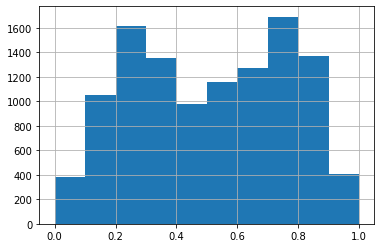

In [6]:
full_df.sentiment_value.hist(bins=10)

# creating sentiment label based on value

In [7]:
## negative - <=0.4
## positive - >=0.6
## neutral - between 0.4 to 0.6

full_df['label'] = np.where(full_df['sentiment_value'] < 0.4, 'negative', 
                              (np.where(full_df['sentiment_value'] > 0.6, 'positive', 'neutral')))
full_df.head()

,sentence_index,sentence,sentiment_value,label
0,1,"The Rock is destined to be the 21st Century 's new `` Conan '' and that he 's going to make a splash even greater than Arnold Schwarzenegger , Jean-Claud Van Damme or Steven Segal",0.69444,positive
1,2,The gorgeously elaborate continuation of `` The Lord of the Rings '' trilogy is so huge that a column of words can not adequately describe co-writer\/director Peter Jackson 's expanded vision of JRR Tolkien 's Middle-earth,0.83333,positive
2,3,Effective but too-tepid biopic,0.51389,neutral
3,4,"If you sometimes like to go to the movies to have fun , Wasabi is a good place to start",0.73611,positive
4,5,"Emerges as something rare , an issue movie that 's so honest and keenly observed that it does n't feel like one",0.86111,positive


# Dividing into train and test

In [8]:
train_df = full_df.sample(frac = 0.7, random_state=43) 
test_df = full_df[~full_df.sentence_index.isin(train_df.sentence_index)]
print(full_df.shape, train_df.shape, test_df.shape)


(11286, 4) (7900, 4) (3386, 4)


# Data Augmentation

In [9]:
## We will use 3 methods for augmentation - random delete, random swap and back translate
## we will randomly pick some sentences which are long enogh and apply these augmentations
## we will then append the augmented data to the origina training data


train_df['words'] = train_df['sentence'].str.split().apply(len)
train_df.head()

,sentence_index,sentence,sentiment_value,label,words
8175,8562,"There 's an audience for it , but it could have been funnier and more innocent",0.38889,negative,16
1430,1489,"For those who pride themselves on sophisticated , discerning taste , this might not seem like the proper cup of tea , however it is almost guaranteed that even the stuffiest cinema goers will laugh their \*\*\* off for an hour-and-a-half",0.83333,positive,41
4286,4481,A gripping documentary that reveals how deep the antagonism lies in war-torn Jerusalem,0.63889,positive,13
4367,4566,Those moviegoers who would automatically bypass a hip-hop documentary should give `` Scratch '' a second look,0.81944,positive,17
5498,5750,The characters are never more than sketches which leaves any true emotional connection or identification frustratingly out of reach,0.12500,negative,19


In [10]:
def random_deletion(words, p=0.5):
    remaining = list(filter(lambda x: random.uniform(0,1) > p,words)) 
    if len(remaining) == 0:
        return [random.choice(words)] 
    else:
        return remaining

In [11]:
def random_swap(sentence, n=5): 
    length = range(len(sentence)) 
    for _ in range(n):
        idx1, idx2 = random.sample(length, 2)
        sentence[idx1], sentence[idx2] = sentence[idx2], sentence[idx1] 
    return sentence

In [12]:
!pip3 install googletrans==3.1.0a0
import random
import googletrans
from googletrans import Translator

     |████████████████████████████████| 61kB 7.2MB/s 
     |████████████████████████████████| 51kB 5.6MB/s 
     |████████████████████████████████| 1.0MB 17.4MB/s 
     |████████████████████████████████| 71kB 10.7MB/s 
     |████████████████████████████████| 61kB 10.0MB/s 
     |████████████████████████████████| 102kB 14.5MB/s 
  Created wheel for googletrans: filename=googletrans-3.1.0a0-cp36-none-any.whl size=16368 sha256=56f95a67701213858eecf11ddbfcabf4e6a63b2f55dea154bbafe89a835c5e65
  Stored in directory: /root/.cache/pip/wheels/27/7a/a0/aff3babbb775549ce6813cb8fa7ff3c0848c4dc62c20f8fdac
  Created wheel for contextvars: filename=contextvars-2.4-cp36-none-any.whl size=7667 sha256=d93ae135344abe4dd663a017e131b559cf6959c88ae80b3c6b8e8e5c9d179e60
  Stored in directory: /root/.cache/pip/wheels/a5/7d/68/1ebae2668bda2228686e3c1cf16f2c2384cea6e9334ad5f6de
Successfully built googletrans contextvars


In [13]:
def back_translate(sentence):
  translator = Translator()
  available_langs = list(googletrans.LANGUAGES.keys())
  trans_lang = random.choice(available_langs)
  print(googletrans.LANGUAGES[trans_lang])
  translations = translator.translate(sentence, dest=trans_lang)
  print(translations)
  translations_en_random = translator.translate(translations.text, src=trans_lang, dest='en') 
  return translations_en_random.text



In [14]:
print(train_df.shape)
print(train_df[train_df.words>10].shape)

(7900, 5)
(6081, 5)


In [15]:
for_translate_df= train_df[train_df.words>10].sample(n=100,random_state=43)
for_translate_df1 = for_translate_df.copy()
for_translate_df1['sentence'] = for_translate_df1['sentence'].apply(back_translate)

hebrew
Translated(src=en, dest=iw, text=לעתים קרובות זה משעשע בקלילות, אבל הבעיות של הדמויות אף פעם לא הופכות להיות חשובות לנו, והסיפור לעולם לא תופס, pronunciation=It 's often faintly amusing , but the problems of the characters never become important to us , and the story never takes hold , extra_data="{'translat...")
marathi
Translated(src=en, dest=mr, text=अलिकडे आणि कोणतीही वास्तविक कच्ची भावना नसते, जी वैयक्तिक संबंधांवर अवलंबून असलेल्या चित्रपटासाठी घातक आहे, pronunciation=Alikaḍē āṇi kōṇatīhī vāstavika kaccī bhāvanā nasatē, jī vaiyaktika sambandhānvara avalambūna asalēlyā citrapaṭāsāṭhī ghātaka āhē, extra_data="{'translat...")
tamil
Translated(src=en, dest=ta, text=இது 1967 ஐ 20 ஆம் நூற்றாண்டின் முக்கிய திருப்புமுனையாகக் கருதி, தெருக்களில் உள்ள அதிருப்தியாளர்களின் படங்களுக்கு மீண்டும் மீண்டும் திரும்பும்போது, ​​அது ஆபத்தான நடப்பு, pronunciation=Itu 1967 ai 20 ām nūṟṟāṇṭiṉ mukkiya tiruppumuṉaiyākak karuti, terukkaḷil uḷḷa atiruptiyāḷarkaḷiṉ paṭaṅkaḷukku mīṇṭum mīṇṭum tirumpumpōt

In [16]:
print(for_translate_df.shape)
for_translate_df.head()

(100, 5)


,sentence_index,sentence,sentiment_value,label,words
7755,8121,"It 's often faintly amusing , but the problems of the characters never become important to us , and the story never takes hold",0.37500,negative,24
9397,9845,"Aloof and lacks any real raw emotion , which is fatal for a film that relies on personal relationships",0.19444,negative,19
1466,1527,"While it regards 1967 as the key turning point of the 20th century , and returns again and again to images of dissidents in the streets , it 's alarmingly current",0.43056,neutral,31
3601,3765,It 's incredible the number of stories the Holocaust has generated,0.66667,positive,11
6806,7120,"It is most of the things Costner movies are known for ; it 's sanctimonious , self-righteous and so eager to earn our love that you want to slap it",0.33333,negative,30


In [17]:
print(for_translate_df1.shape)
for_translate_df1.head()

(100, 5)


,sentence_index,sentence,sentiment_value,label,words
7755,8121,"It's often amusing, but the characters' problems never become important to us, and the story never catches on.",0.37500,negative,24
9397,9845,"Lately and there is no real raw emotion, which is dangerous for a film that relies on personal relationships",0.19444,negative,19
1466,1527,"Considering 1967 as a major turning point in the 20th century, when it comes back to the images of dissidents on the streets, it is a dangerous current.",0.43056,neutral,31
3601,3765,These are the amazing numbers that the Holocaust created,0.66667,positive,11
6806,7120,"That’s most of the things that Costner movies are known for; its sacred, selfish and so eager to earn our love that you want to beat it",0.33333,negative,30


In [18]:
for_random_deletion_df= train_df[train_df.words>10].sample(frac=0.5,random_state=10)
print(for_random_deletion_df.shape)
for_random_deletion_df1 = for_random_deletion_df.copy()
for_random_deletion_df1['sentence'] = for_random_deletion_df1.sentence.str.split().apply(random_deletion).apply(' '.join)

(3040, 5)


In [19]:
for_random_deletion_df1.shape

(3040, 5)

In [20]:
for_random_swap_df= train_df[train_df.words>10].sample(frac=0.5,random_state=16)
print(for_random_swap_df.shape)
for_random_swap_df1 = for_random_swap_df.copy()
for_random_swap_df1['sentence'] = for_random_swap_df1.sentence.str.split().apply(random_swap).apply(' '.join)

(3040, 5)


In [21]:
augmented_train_df = pd.concat([train_df,for_random_deletion_df1,for_random_swap_df1,for_translate_df1], axis=0).reset_index(drop=True)

In [22]:
augmented_train_df = augmented_train_df[['sentence','label']]
test_df = test_df[['sentence','label']].reset_index(drop=True)

In [23]:
augmented_train_df.head()

,sentence,label
0,"There 's an audience for it , but it could have been funnier and more innocent",negative
1,"For those who pride themselves on sophisticated , discerning taste , this might not seem like the proper cup of tea , however it is almost guaranteed that even the stuffiest cinema goers will laugh their \*\*\* off for an hour-and-a-half",positive
2,A gripping documentary that reveals how deep the antagonism lies in war-torn Jerusalem,positive
3,Those moviegoers who would automatically bypass a hip-hop documentary should give `` Scratch '' a second look,positive
4,The characters are never more than sketches which leaves any true emotional connection or identification frustratingly out of reach,negative


In [24]:
test_df.head()

,sentence,label
0,Offers that rare combination of entertainment and education,positive
1,Perhaps no picture ever made has more literally showed that the road to hell is paved with good intentions,positive
2,"This is a film well worth seeing , talking and singing heads and all",positive
3,An utterly compelling ` who wrote it ' in which the reputation of the most famous author who ever lived comes into question,positive
4,Scores a few points for doing what it does with a dedicated and good-hearted professionalism,positive


In [25]:
augmented_train_df.label.value_counts()

positive    5948
negative    5498
neutral     2634
Name: label, dtype: int64

In [26]:
Sentence = data.Field(sequential = True, tokenize = 'spacy', batch_first =True, include_lengths=True)
Label = data.LabelField(tokenize ='spacy', is_target=True, batch_first =True, sequential =False)

In [27]:
fields = [('sentence', Sentence),('label',Label)]

In [28]:
train_example = [data.Example.fromlist([augmented_train_df.sentence[i],augmented_train_df.label[i]], fields) for i in range(augmented_train_df.shape[0])] 

test_example = [data.Example.fromlist([test_df.sentence[i],test_df.label[i]], fields) for i in range(test_df.shape[0])]

In [29]:
train_data = data.Dataset(train_example, fields)

test_data = data.Dataset(test_example, fields)

In [30]:
(len(train_data), len(test_data))

(14080, 3386)

In [31]:
vars(train_data.examples[2000])

{'label': 'negative',
 'sentence': ['The',
  'big',
  '-',
  'screen',
  'Scooby',
  'makes',
  'the',
  'silly',
  'original',
  'cartoon',
  'seem',
  'smart',
  'and',
  'well',
  '-',
  'crafted',
  'in',
  'comparison']}

In [32]:
Sentence.build_vocab(train_data, max_size = 7000)
Label.build_vocab(train_data)

In [33]:
print('Size of input vocab : ', len(Sentence.vocab))
print('Size of label vocab : ', len(Label.vocab))
print('Top 10 words appreared repeatedly :', list(Sentence.vocab.freqs.most_common(10)))
print('Labels : ', Label.vocab.stoi)

Size of input vocab :  7002
Size of label vocab :  3
Top 10 words appreared repeatedly : [(',', 11329), ('the', 9713), ('a', 7010), ('of', 6960), ('and', 6878), ('to', 4891), ('-', 4267), ('is', 3990), ("'s", 3838), ('that', 2978)]
Labels :  defaultdict(<function _default_unk_index at 0x7fbf4c721ea0>, {'positive': 0, 'negative': 1, 'neutral': 2})


In [34]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [35]:
train_iterator, valid_iterator = data.BucketIterator.splits((train_data, test_data), batch_size = 32, 
                                                            sort_key = lambda x: len(x.sentence),
                                                            sort_within_batch=True, device = device)

In [36]:
import os, pickle
with open('tokenizer.pkl', 'wb') as tokens: 
    pickle.dump(Sentence.vocab.stoi, tokens)

In [37]:
import torch.nn as nn
import torch.nn.functional as F

class classifier(nn.Module):
    
    # Define all the layers used in model
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, dropout):
        
        super().__init__()          
        
        # Embedding layer
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        
        # LSTM layer
        self.encoder = nn.LSTM(embedding_dim, 
                           hidden_dim, 
                           num_layers=n_layers, 
                           dropout=dropout,
                           batch_first=True)
        # try using nn.GRU or nn.RNN here and compare their performances
        # try bidirectional and compare their performances
        
        # Dense layer
        self.fc = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, text, text_lengths):
        
        # text = [batch size, sent_length]
        embedded = self.embedding(text)
        # embedded = [batch size, sent_len, emb dim]
      
        # packed sequence
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, text_lengths.cpu(), batch_first=True)
        
        packed_output, (hidden, cell) = self.encoder(packed_embedded)
        #hidden = [batch size, num layers * num directions,hid dim]
        #cell = [batch size, num layers * num directions,hid dim]
    
        # Hidden = [batch size, hid dim * num directions]
        dense_outputs = self.fc(hidden)   
        
        # Final activation function softmax
        output = F.softmax(dense_outputs[0], dim=1)
            
        return output

In [38]:
# Define hyperparameters
size_of_vocab = len(Sentence.vocab)
embedding_dim = 300
num_hidden_nodes = 100
num_output_nodes = 3
num_layers = 2
dropout = 0.3

# Instantiate the model
model = classifier(size_of_vocab, embedding_dim, num_hidden_nodes, num_output_nodes, num_layers, dropout = dropout)

In [39]:
print(model)

#No. of trianable parameters
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
    
print(f'The model has {count_parameters(model):,} trainable parameters')

classifier(
  (embedding): Embedding(7002, 300)
  (encoder): LSTM(300, 100, num_layers=2, batch_first=True, dropout=0.3)
  (fc): Linear(in_features=100, out_features=3, bias=True)
)
The model has 2,342,503 trainable parameters


In [40]:
import torch.optim as optim

# define optimizer and loss
optimizer = optim.Adam(model.parameters(), lr=2e-4)
criterion = nn.CrossEntropyLoss()

# define metric
def binary_accuracy(preds, y):
    #round predictions to the closest integer
    _, predictions = torch.max(preds, 1)
    
    correct = (predictions == y).float() 
    acc = correct.sum() / len(correct)
    return acc
    
# push to cuda if available
model = model.to(device)
criterion = criterion.to(device)

In [41]:
def train(model, iterator, optimizer, criterion):
    
    # initialize every epoch 
    epoch_loss = 0
    epoch_acc = 0
    
    # set the model in training phase
    model.train()  
    
    for batch in iterator:
        
        # resets the gradients after every batch
        optimizer.zero_grad()   
        
        # retrieve text and no. of words
        sentence, sentence_lengths = batch.sentence   
        
        # convert to 1D tensor
        predictions = model(sentence, sentence_lengths).squeeze()  
        
        # compute the loss
        loss = criterion(predictions, batch.label)        
        
        # compute the binary accuracy
        acc = binary_accuracy(predictions, batch.label)   
        
        # backpropage the loss and compute the gradients
        loss.backward()       
        
        # update the weights
        optimizer.step()      
        
        # loss and accuracy
        epoch_loss += loss.item()  
        epoch_acc += acc.item()    
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [42]:
def evaluate(model, iterator, criterion):
    
    # initialize every epoch
    epoch_loss = 0
    epoch_acc = 0

    # deactivating dropout layers
    model.eval()
    
    # deactivates autograd
    with torch.no_grad():
    
        for batch in iterator:
        
            # retrieve text and no. of words
            sentence, sentence_lengths = batch.sentence 
            
            # convert to 1d tensor
            predictions = model(sentence, sentence_lengths).squeeze()
            
            # compute loss and accuracy
            loss = criterion(predictions, batch.label)
            acc = binary_accuracy(predictions, batch.label)
            
            # keep track of loss and accuracy
            epoch_loss += loss.item()
            epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [43]:
N_EPOCHS = 10
best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):
     
    # train the model
    train_loss, train_acc = train(model, train_iterator, optimizer, criterion)
    
    # evaluate the model
    valid_loss, valid_acc = evaluate(model, valid_iterator, criterion)
    
    # save the best model
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'saved_weights.pt')
    
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}% \n')

	Train Loss: 1.055 | Train Acc: 45.77%
	 Val. Loss: 1.026 |  Val. Acc: 50.06% 

	Train Loss: 0.973 | Train Acc: 57.37%
	 Val. Loss: 0.986 |  Val. Acc: 54.45% 

	Train Loss: 0.903 | Train Acc: 64.82%
	 Val. Loss: 0.961 |  Val. Acc: 57.49% 

	Train Loss: 0.857 | Train Acc: 69.81%
	 Val. Loss: 0.952 |  Val. Acc: 58.58% 

	Train Loss: 0.826 | Train Acc: 72.84%
	 Val. Loss: 0.947 |  Val. Acc: 58.88% 

	Train Loss: 0.805 | Train Acc: 74.92%
	 Val. Loss: 0.947 |  Val. Acc: 58.97% 

	Train Loss: 0.789 | Train Acc: 76.52%
	 Val. Loss: 0.943 |  Val. Acc: 59.57% 

	Train Loss: 0.774 | Train Acc: 77.78%
	 Val. Loss: 0.947 |  Val. Acc: 59.20% 

	Train Loss: 0.763 | Train Acc: 79.03%
	 Val. Loss: 0.945 |  Val. Acc: 59.25% 

	Train Loss: 0.748 | Train Acc: 80.70%
	 Val. Loss: 0.954 |  Val. Acc: 57.98% 

